## Installing Captum

In [ ]:
!git clone https://github.com/pytorch/captum
%cd captum
!git checkout "optim-wip"
!pip3 install -e .
import sys
sys.path.append('/content/captum')
%cd ..

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='torch')

fatal: destination path 'captum' already exists and is not an empty directory.
/content/captum
Already on 'optim-wip'
Your branch is up to date with 'origin/optim-wip'.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/captum
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Running setup.py develop for captum
/content


## Create custom ResNet-18 class to convert non-linear operations to linear operations

In [ ]:

import torch
import torch.nn as nn
from functools import partial
from torch import Tensor
from torchvision.utils import _log_api_usage_once
from torchvision.models._api import register_model, Weights, WeightsEnum
from torchvision.transforms._presets import ImageClassification
from torchvision.models._meta import _IMAGENET_CATEGORIES
from torchvision.models._utils import _ovewrite_named_param
from typing import Any, Callable, List, Optional, Type, Union
from captum.optim.models._common import Conv2dSame, RedirectedReluLayer, SkipLayer

_COMMON_META = {
    "min_size": (1, 1),
    "categories": _IMAGENET_CATEGORIES,
}

class ResNet18_Weights(WeightsEnum):
    IMAGENET1K_V1 = Weights(
        url="https://download.pytorch.org/models/resnet18-f37072fd.pth",
        transforms=partial(ImageClassification, crop_size=224),
        meta={
            **_COMMON_META,
            "num_params": 11689512,
            "recipe": "https://github.com/pytorch/vision/tree/main/references/classification#resnet",
            "_metrics": {
                "ImageNet-1K": {
                    "acc@1": 69.758,
                    "acc@5": 89.078,
                }
            },
            "_ops": 1.814,
            "_file_size": 44.661,
            "_docs": """These weights reproduce closely the results of the paper using a simple training recipe.""",
        },
    )
    DEFAULT = IMAGENET1K_V1

def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=dilation,
        groups=groups,
        bias=False,
        dilation=dilation,
    )

class BasicBlock(nn.Module):
    expansion: int = 1

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
        use_linear_modules_only: bool = False,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError("BasicBlock only supports groups=1 and base_width=64")
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        if use_linear_modules_only:
          self.relu = SkipLayer()
        else:
          self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition" https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion: int = 4

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
        use_linear_modules_only: bool = False,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.0)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        if use_linear_modules_only:
          self.relu = SkipLayer()
        else:
          self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class ResNet(nn.Module):
    def __init__(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        layers: List[int],
        num_classes: int = 1000,
        zero_init_residual: bool = False,
        groups: int = 1,
        width_per_group: int = 64,
        replace_stride_with_dilation: Optional[List[bool]] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
        use_linear_modules_only: bool = False
    ) -> None:
        super().__init__()
        _log_api_usage_once(self)
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError(
                "replace_stride_with_dilation should be None "
                f"or a 3-element tuple, got {replace_stride_with_dilation}"
            )
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = norm_layer(self.inplanes)
        if use_linear_modules_only:
          self.use_linear_modules_only = True
          self.relu = SkipLayer()
          self.maxpool = nn.AvgPool2d(kernel_size=3, stride=2, padding=1)
        else:
          self.use_linear_modules_only = True
          self.relu = nn.ReLU(inplace=True)
          self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck) and m.bn3.weight is not None:
                    nn.init.constant_(m.bn3.weight, 0)  # type: ignore[arg-type]
                elif isinstance(m, BasicBlock) and m.bn2.weight is not None:
                    nn.init.constant_(m.bn2.weight, 0)  # type: ignore[arg-type]

    def _make_layer(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        planes: int,
        blocks: int,
        stride: int = 1,
        dilate: bool = False,
    ) -> nn.Sequential:
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(
            block(
                self.inplanes, planes, stride, downsample, self.groups, self.base_width, previous_dilation, norm_layer, self.use_linear_modules_only
            )
        )
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(
                block(
                    self.inplanes,
                    planes,
                    groups=self.groups,
                    base_width=self.base_width,
                    dilation=self.dilation,
                    norm_layer=norm_layer,
                )
            )

        return nn.Sequential(*layers)

    def _forward_impl(self, x: Tensor) -> Tensor:
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)

def build_resnet(
    block: Type[Union[BasicBlock, Bottleneck]],
    layers: List[int],
    weights: Optional[WeightsEnum],
    progress: bool,
    use_linear_modules_only: bool = False,
    **kwargs: Any,
) -> ResNet:
    if weights is not None:
        _ovewrite_named_param(kwargs, "num_classes", len(weights.meta["categories"]))

    model = ResNet(block, layers, use_linear_modules_only=use_linear_modules_only, **kwargs)

    if weights is not None:
        model.load_state_dict(weights.get_state_dict(progress=progress))

    return model

## Initiliasing ResNet-18 linear and standard models

In [ ]:
from torchvision.models.resnet import ResNeXt101_32X8D_Weights

import torch
import torchvision
from torchvision.models import resnet18

import captum.optim as optimviz

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
weights = ResNet18_Weights.verify("IMAGENET1K_V1")
model = build_resnet(BasicBlock, [2, 2, 2, 2], weights=weights, progress=True).to(device).eval()
linear_model = build_resnet(BasicBlock, [2, 2, 2, 2], weights=weights, progress=True, use_linear_modules_only=True).to(device).eval()

In [ ]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): SkipLayer()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (co

In [ ]:
linear_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): SkipLayer()
  (maxpool): AvgPool2d(kernel_size=3, stride=2, padding=1)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): SkipLayer()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3,

In [ ]:
import torch

from lucent.optvis import render, param, transform, objectives
from lucent.modelzoo.util import get_model_layers

get_model_layers(model)

['conv1',
 'bn1',
 'relu',
 'maxpool',
 'layer1',
 'layer1_0',
 'layer1_0_conv1',
 'layer1_0_bn1',
 'layer1_0_relu',
 'layer1_0_conv2',
 'layer1_0_bn2',
 'layer1_1',
 'layer1_1_conv1',
 'layer1_1_bn1',
 'layer1_1_relu',
 'layer1_1_conv2',
 'layer1_1_bn2',
 'layer2',
 'layer2_0',
 'layer2_0_conv1',
 'layer2_0_bn1',
 'layer2_0_relu',
 'layer2_0_conv2',
 'layer2_0_bn2',
 'layer2_0_downsample',
 'layer2_0_downsample_0',
 'layer2_0_downsample_1',
 'layer2_1',
 'layer2_1_conv1',
 'layer2_1_bn1',
 'layer2_1_relu',
 'layer2_1_conv2',
 'layer2_1_bn2',
 'layer3',
 'layer3_0',
 'layer3_0_conv1',
 'layer3_0_bn1',
 'layer3_0_relu',
 'layer3_0_conv2',
 'layer3_0_bn2',
 'layer3_0_downsample',
 'layer3_0_downsample_0',
 'layer3_0_downsample_1',
 'layer3_1',
 'layer3_1_conv1',
 'layer3_1_bn1',
 'layer3_1_relu',
 'layer3_1_conv2',
 'layer3_1_bn2',
 'layer4',
 'layer4_0',
 'layer4_0_conv1',
 'layer4_0_bn1',
 'layer4_0_relu',
 'layer4_0_conv2',
 'layer4_0_bn2',
 'layer4_0_downsample',
 'layer4_0_downsampl

In [ ]:
from typing import Callable, Dict, List, Optional, Tuple
import numpy as np
import matplotlib.pyplot as plt

LossFunction = Callable[[Dict[torch.nn.Module, Optional[torch.Tensor]]], torch.Tensor]


def show(
    x: torch.Tensor, figsize: Optional[Tuple[int, int]] = None, scale: float = 255.0
) -> None:
    assert x.dim() == 3 or x.dim() == 4
    x = x[0] if x.dim() == 4 else x
    x = x.cpu().permute(1, 2, 0) * scale
    if figsize is not None:
        plt.figure(figsize=figsize)
    plt.imshow(x.numpy().astype(np.uint8))
    plt.axis("off")
    plt.show()


def vis_neuron_large(
    model: torch.nn.Module, target: torch.nn.Module, channel: int
) -> None:
    image = optimviz.images.NaturalImage((224, 224)).to(device)
    transforms = torch.nn.Sequential(
        torch.nn.ReflectionPad2d(16),
        optimviz.transforms.RandomSpatialJitter(16),
        optimviz.transforms.RandomScale(scale=(1, 0.975, 1.025, 0.95, 1.05)),
        torchvision.transforms.RandomRotation(degrees=(-5, 5)),
        optimviz.transforms.RandomSpatialJitter(8),
        optimviz.transforms.CenterCrop((224, 224)),
    )
    loss_fn = optimviz.loss.NeuronActivation(target, channel)
    obj = optimviz.InputOptimization(model, loss_fn, image, transforms)
    history = obj.optimize(optimviz.optimization.n_steps(128))
    image().show()


def vis_neuron(
    model: torch.nn.Module, target: torch.nn.Module, loss_fn: LossFunction
) -> torch.Tensor:
    image = optimviz.images.NaturalImage((60, 60)).to(device)
    transforms = torch.nn.Sequential(
        torch.nn.ReflectionPad2d(4),
        optimviz.transforms.RandomSpatialJitter(8),
        optimviz.transforms.RandomScale(scale=(1, 0.975, 1.025, 0.95, 1.05)),
        torchvision.transforms.RandomRotation(degrees=(-5, 5)),
        optimviz.transforms.RandomSpatialJitter(2),
        optimviz.transforms.CenterCrop((60, 60)),
    )
    obj = optimviz.InputOptimization(model, loss_fn, image, transforms)
    history = obj.optimize(optimviz.optimization.n_steps(128, False))
    return image()


def visualize_neuron_list(
    model: torch.nn.Module, target: torch.nn.Module, neuron_list: List[int]
) -> List[torch.Tensor]:
    A = []
    for n in neuron_list:
        loss_fn = optimviz.loss.NeuronActivation(target, n)
        x_out = vis_neuron(model, target, loss_fn)
        A.append(x_out.detach())
    return A

## Extended Weight Matrics

### Helper functions

In [ ]:
from typing import Callable, Dict, List, Optional, Tuple
import numpy as np
import matplotlib.pyplot as plt

LossFunction = Callable[[Dict[torch.nn.Module, Optional[torch.Tensor]]], torch.Tensor]


def show(
    x: torch.Tensor, figsize: Optional[Tuple[int, int]] = None, scale: float = 255.0
) -> None:
    assert x.dim() == 3 or x.dim() == 4
    x = x[0] if x.dim() == 4 else x
    x = x.cpu().permute(1, 2, 0) * scale
    if figsize is not None:
        plt.figure(figsize=figsize)
    plt.imshow(x.numpy().astype(np.uint8))
    plt.axis("off")
    plt.show()


def vis_neuron_large(
    model: torch.nn.Module, target: torch.nn.Module, channel: int
) -> None:
    image = optimviz.images.NaturalImage((224, 224)).to(device)
    transforms = torch.nn.Sequential(
        torch.nn.ReflectionPad2d(16),
        optimviz.transforms.RandomSpatialJitter(16),
        optimviz.transforms.RandomScale(scale=(1, 0.975, 1.025, 0.95, 1.05)),
        torchvision.transforms.RandomRotation(degrees=(-5, 5)),
        optimviz.transforms.RandomSpatialJitter(8),
        optimviz.transforms.CenterCrop((224, 224)),
    )
    loss_fn = optimviz.loss.NeuronActivation(target, channel)
    obj = optimviz.InputOptimization(model, loss_fn, image, transforms)
    history = obj.optimize(optimviz.optimization.n_steps(128))
    image().show()


def vis_neuron(
    model: torch.nn.Module, target: torch.nn.Module, loss_fn: LossFunction
) -> torch.Tensor:
    image = optimviz.images.NaturalImage((60, 60)).to(device)
    transforms = torch.nn.Sequential(
        torch.nn.ReflectionPad2d(4),
        optimviz.transforms.RandomSpatialJitter(8),
        optimviz.transforms.RandomScale(scale=(1, 0.975, 1.025, 0.95, 1.05)),
        torchvision.transforms.RandomRotation(degrees=(-5, 5)),
        optimviz.transforms.RandomSpatialJitter(2),
        optimviz.transforms.CenterCrop((60, 60)),
    )
    obj = optimviz.InputOptimization(model, loss_fn, image, transforms)
    history = obj.optimize(optimviz.optimization.n_steps(128, False))
    return image()


def visualize_neuron_list(
    model: torch.nn.Module, target: torch.nn.Module, neuron_list: List[int]
) -> List[torch.Tensor]:
    A = []
    for n in neuron_list:
        loss_fn = optimviz.loss.NeuronActivation(target, n)
        x_out = vis_neuron(model, target, loss_fn)
        A.append(x_out.detach())
    return A

### Extended Weight matrices between Layer1, Layer2, Layer3 and Layer4

There are many zero activation channels in these extended weight matrcies potentially due to skip connections.

In [ ]:
layers = ['layer1', 'layer2', 'layer3', 'layer4']

print("Layer1 - Layer2")
W = optimviz.circuits.extract_expanded_weights(linear_model, linear_model.layer1, linear_model.layer2, 5)
print(f"Shape of extended matrix: {W.shape}")
good_channels = torch.unique(torch.where(W != 0)[0], sorted=True)
print(f"Number of non-zero channel weight activations: {len(good_channels)}")

Layer1 - Layer2
Shape of extended matrix: torch.Size([128, 64, 5, 5])
Number of non-zero channel weight activations: 79


In [ ]:
print("Layer1 - Layer3")
W = optimviz.circuits.extract_expanded_weights(linear_model, linear_model.layer1, linear_model.layer3, 5)
print(f"Shape of extended matrix: {W.shape}")
good_channels = torch.unique(torch.where(W != 0)[0], sorted=True)
print(f"Number of non-zero channel weight activations: {len(good_channels)}")

Layer1 - Layer3
Shape of extended matrix: torch.Size([256, 64, 5, 5])
Number of non-zero channel weight activations: 44


In [ ]:
print("Layer1 - Layer4")
W = optimviz.circuits.extract_expanded_weights(linear_model, linear_model.layer1, linear_model.layer4, 5)
print(f"Shape of extended matrix: {W.shape}")
good_channels = torch.unique(torch.where(W != 0)[0], sorted=True)
print(f"Number of non-zero channel weight activations: {len(good_channels)}")

Layer1 - Layer4
Shape of extended matrix: torch.Size([512, 64, 5, 5])
Number of non-zero channel weight activations: 19


In [ ]:
print("Layer2 - Layer3")
W = optimviz.circuits.extract_expanded_weights(linear_model, linear_model.layer2, linear_model.layer3, 5)
print(f"Shape of extended matrix: {W.shape}")
good_channels = torch.unique(torch.where(W != 0)[0], sorted=True)
print(f"Number of non-zero channel weight activations: {len(good_channels)}")

Layer2 - Layer3
Shape of extended matrix: torch.Size([256, 128, 5, 5])
Number of non-zero channel weight activations: 44


In [ ]:
print("Layer2 - Layer4")
W = optimviz.circuits.extract_expanded_weights(linear_model, linear_model.layer2, linear_model.layer4, 5)
print(f"Shape of extended matrix: {W.shape}")
good_channels = torch.unique(torch.where(W != 0)[0], sorted=True)
print(f"Number of non-zero channel weight activations: {len(good_channels)}")

Layer2 - Layer4
Shape of extended matrix: torch.Size([512, 128, 5, 5])
Number of non-zero channel weight activations: 19


In [ ]:
print("Layer3 - Layer4")
W = optimviz.circuits.extract_expanded_weights(linear_model, linear_model.layer3, linear_model.layer4, 5)
print(f"Shape of extended matrix: {W.shape}")
good_channels = torch.unique(torch.where(W != 0)[0], sorted=True)
print(f"Number of non-zero channel weight activations: {len(good_channels)}")

Layer3 - Layer4
Shape of extended matrix: torch.Size([512, 256, 5, 5])
Number of non-zero channel weight activations: 19


### Extended Weight matrices between intermediate Conv layers

#### Layer1_0_conv1 - Layer2_1_conv2

In [ ]:
print("Layer1:0 conv1 - Layer2:1 conv2")
W = optimviz.circuits.extract_expanded_weights(linear_model, linear_model.layer1[0].conv1, linear_model.layer2[1].conv2, 5)
print(f"Shape of extended matrix: {W.shape}")
good_channels = torch.unique(torch.where(W != 0)[0], sorted=True)
print(f"Number of non-zero channel weight activations: {len(good_channels)}")

Layer1:0 conv1 - Layer2:1 conv2
Shape of extended matrix: torch.Size([128, 64, 5, 5])
Number of non-zero channel weight activations: 128


In [ ]:
import warnings
warnings.filterwarnings("ignore")

reducer = optimviz.reducer.ChannelReducer(3, "NMF")

# Make the input positive for one-sided NMF
W_posneg = optimviz.reducer.posneg(W, dim=1)

reductions = []

for i in good_channels:
  W_nmf = reducer.fit_transform(W_posneg[i, ...].cpu())
  W_nmf = W_nmf / W_nmf.max()
  reductions.append(W_nmf)

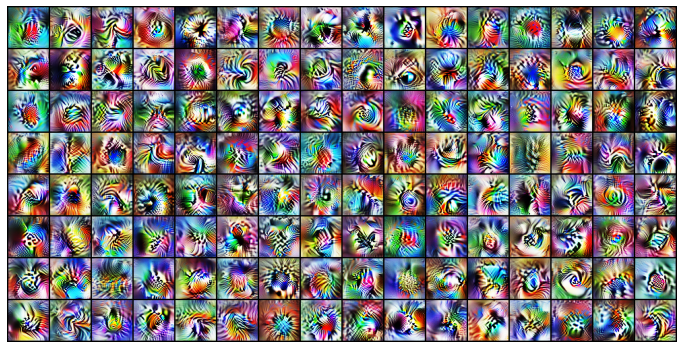

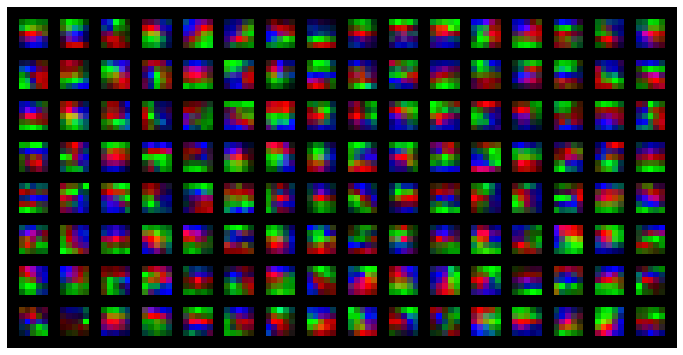

In [ ]:
A = visualize_neuron_list(model, model.layer2[1].conv2, good_channels)
grid_img = torchvision.utils.make_grid(torch.cat(A), nrow=16)
show(grid_img, figsize = (12, 12))

grid_img = torchvision.utils.make_grid(torch.stack(reductions), nrow=16)
show(grid_img, figsize = (12, 12))

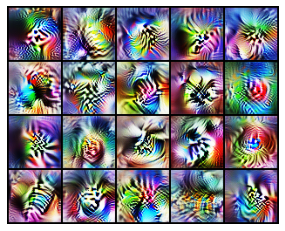

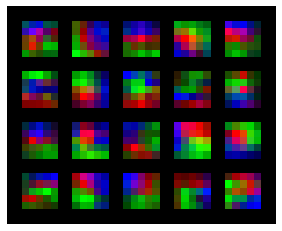

In [ ]:
channels = list(range(80,100))

A = visualize_neuron_list(model, model.layer2[1].conv2, channels)
grid_img = torchvision.utils.make_grid(torch.cat(A), nrow=5)
show(grid_img)

A = []
for i in channels:
    W_nmf = reducer.fit_transform(W_posneg[i, ...])
    W_nmf = W_nmf / W_nmf.max()
    A.append(W_nmf)

grid_img = torchvision.utils.make_grid(torch.stack(A), nrow=5)
show(grid_img)

#### Layer2_0_conv1 - Layer3_1_conv2

In [ ]:
print("Layer2:0 conv1 - Layer3:1 conv2")
W = optimviz.circuits.extract_expanded_weights(linear_model, linear_model.layer2[0].conv1, linear_model.layer3[1].conv2, 5)
print(f"Shape of extended matrix: {W.shape}")
good_channels = torch.unique(torch.where(W != 0)[0], sorted=True)
print(f"Number of non-zero channel weight activations: {len(good_channels)}")

Layer2:0 conv1 - Layer3:1 conv2
Shape of extended matrix: torch.Size([256, 128, 5, 5])
Number of non-zero channel weight activations: 256


In [ ]:
import warnings
warnings.filterwarnings("ignore")

reducer = optimviz.reducer.ChannelReducer(3, "NMF")

# Make the input positive for one-sided NMF
W_posneg = optimviz.reducer.posneg(W, dim=1)

reductions = []

for i in good_channels:
  W_nmf = reducer.fit_transform(W_posneg[i, ...].cpu())
  W_nmf = W_nmf / W_nmf.max()
  reductions.append(W_nmf)

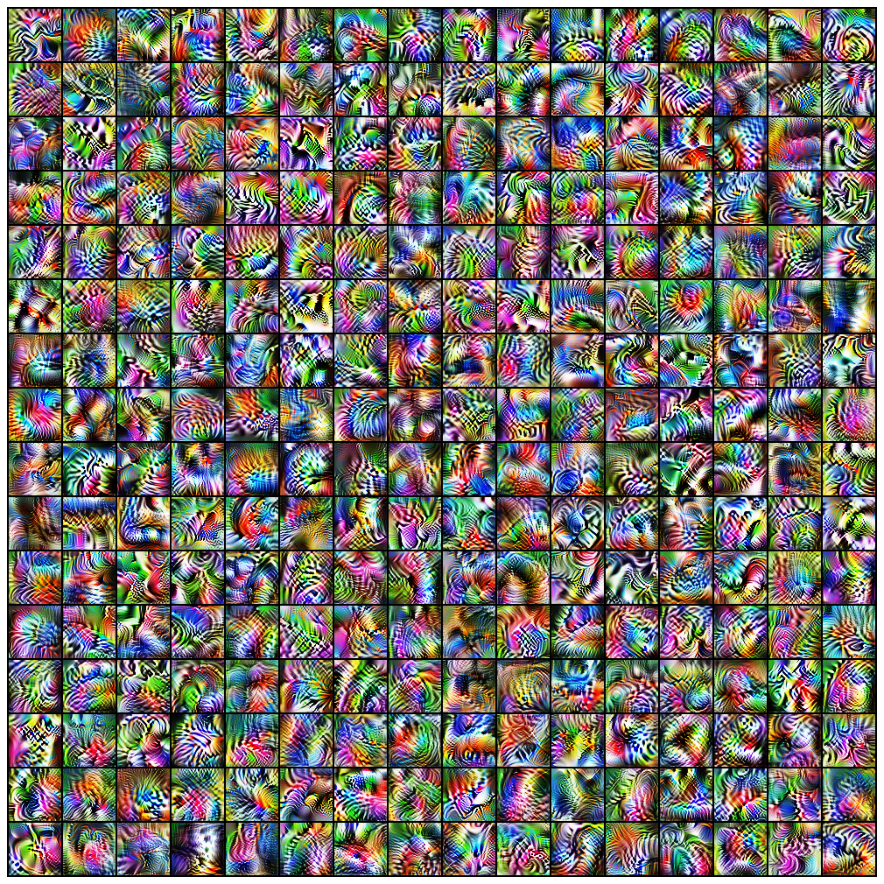

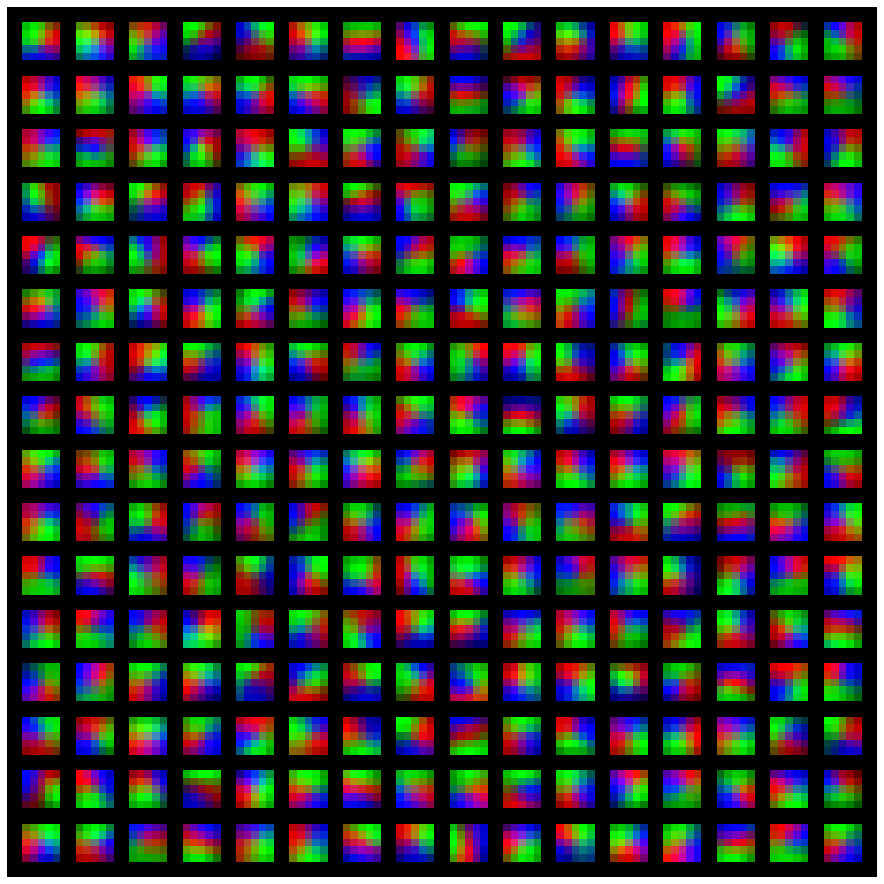

In [ ]:
A = visualize_neuron_list(model, model.layer3[1].conv2, good_channels)
grid_img = torchvision.utils.make_grid(torch.cat(A), nrow=16)
show(grid_img, figsize = (16, 16))

grid_img = torchvision.utils.make_grid(torch.stack(reductions), nrow=16)
show(grid_img, figsize = (16, 16))

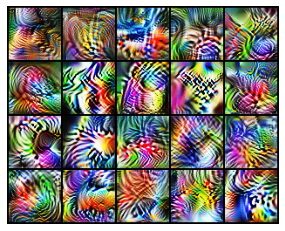

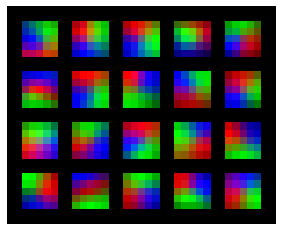

In [ ]:
channels = list(range(200,220))

A = visualize_neuron_list(model, model.layer3[1].conv2, channels)
grid_img = torchvision.utils.make_grid(torch.cat(A), nrow=5)
show(grid_img)

A = []
for i in channels:
    W_nmf = reducer.fit_transform(W_posneg[i, ...])
    W_nmf = W_nmf / W_nmf.max()
    A.append(W_nmf)

grid_img = torchvision.utils.make_grid(torch.stack(A), nrow=5)
show(grid_img)

#### Layer3_0_conv1 - Layer4_1_conv2

In [ ]:
print("Layer3:0 conv1 - Layer4:1 conv2")
W = optimviz.circuits.extract_expanded_weights(linear_model, linear_model.layer3[0].conv1, linear_model.layer4[1].conv2, 5)
print(f"Shape of extended matrix: {W.shape}")
good_channels = torch.unique(torch.where(W != 0)[0], sorted=True)
print(f"Number of non-zero channel weight activations: {len(good_channels)}")

Layer3:0 conv1 - Layer4:1 conv2
Shape of extended matrix: torch.Size([512, 256, 5, 5])
Number of non-zero channel weight activations: 512


In [ ]:
import warnings
warnings.filterwarnings("ignore")

reducer = optimviz.reducer.ChannelReducer(3, "NMF")

# Make the input positive for one-sided NMF
W_posneg = optimviz.reducer.posneg(W, dim=1)

reductions = []

for i in good_channels:
  W_nmf = reducer.fit_transform(W_posneg[i, ...].cpu())
  W_nmf = W_nmf / W_nmf.max()
  reductions.append(W_nmf)

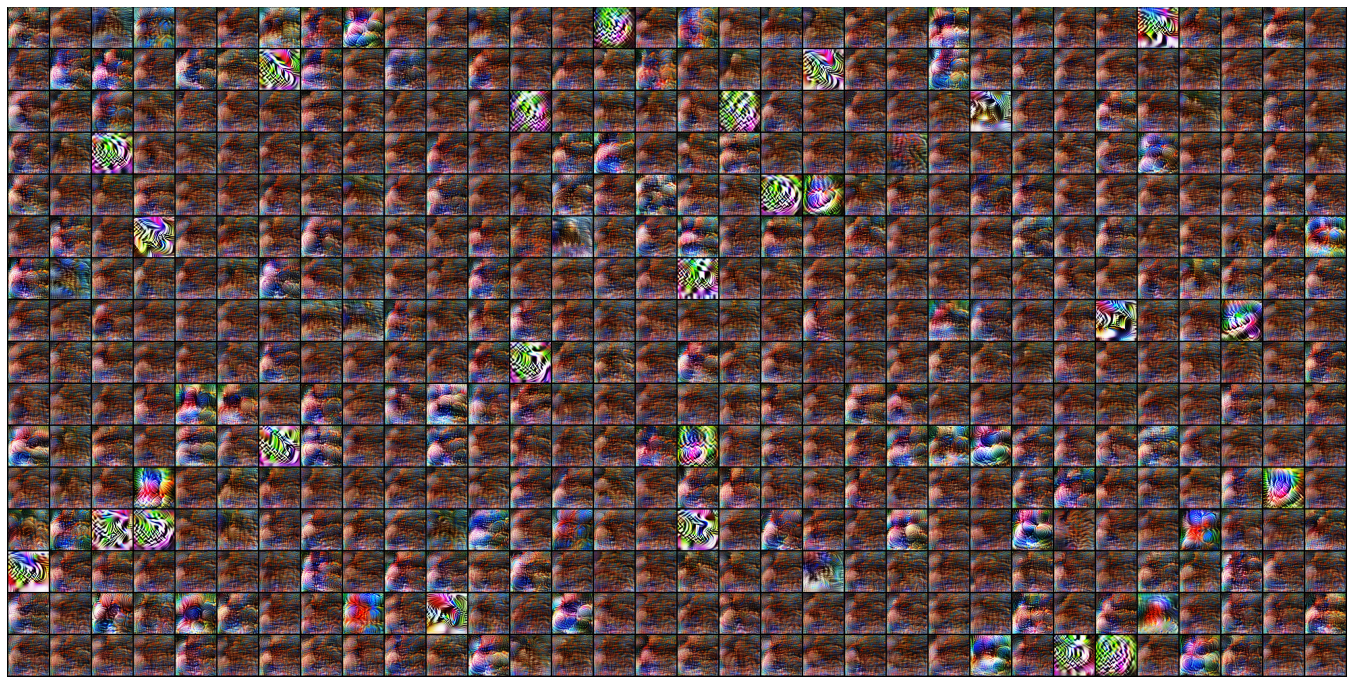

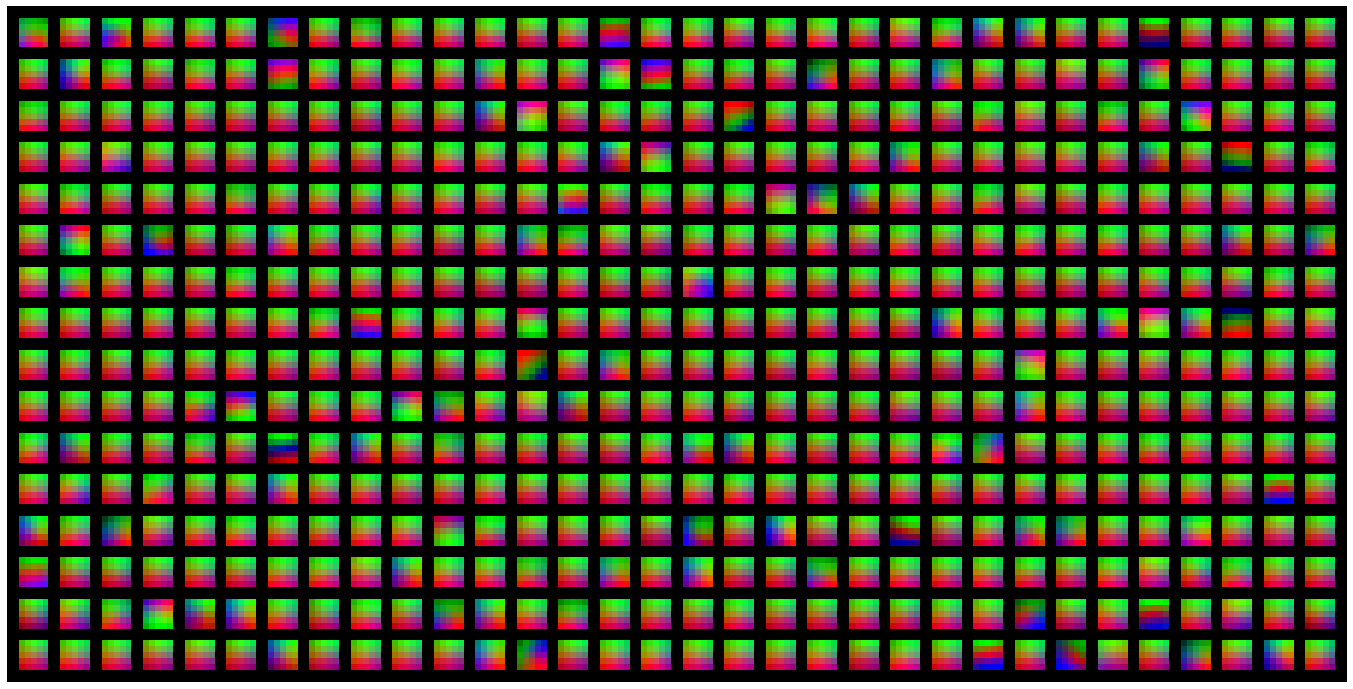

In [ ]:
A = visualize_neuron_list(model, model.layer4[1].conv2, good_channels)
grid_img = torchvision.utils.make_grid(torch.cat(A), nrow=32)
show(grid_img, figsize = (24, 24))

grid_img = torchvision.utils.make_grid(torch.stack(reductions), nrow=32)
show(grid_img, figsize = (24, 24))

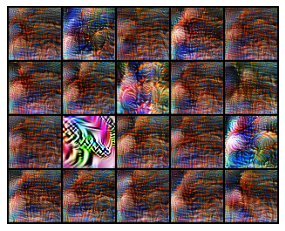

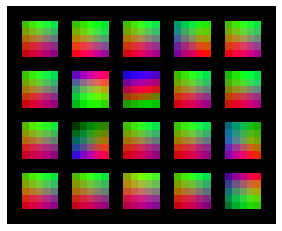

In [ ]:
channels = list(range(40,60))

A = visualize_neuron_list(model, model.layer4[1].conv2, channels)
grid_img = torchvision.utils.make_grid(torch.cat(A), nrow=5)
show(grid_img)

A = []
for i in channels:
    W_nmf = reducer.fit_transform(W_posneg[i, ...])
    W_nmf = W_nmf / W_nmf.max()
    A.append(W_nmf)

grid_img = torchvision.utils.make_grid(torch.stack(A), nrow=5)
show(grid_img)